In [83]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from simpy_helpers import Source, Resource , Stats, Entity
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation


## Initialization

In [84]:

class Stats(Stats):
    mc_waiting_times = []

    @staticmethod
    def add_mc_waiting_time(time):
        Stats.mc_waiting_times.append(time)

    @staticmethod
    def get_mc_waiting_times():
        return Stats.mc_waiting_times
    


class Ship(Entity):
    def __init__(self, env,attributes , my_resource, weather_data):
        super().__init__(env , attributes) 
        self.queue_capacity = queue_capacity
        self.my_resource = my_resource
        self.weather_data = weather_data

    def ship_type(self):
        ship_types = {
           "category" : ["A", "B", "C", "D"],
           "capacity type" : [2000 , 3000 , 4000 , 5000],
           "Cargaison" : [13000 , 26000 , 34000 , 51000],
           "Composition" :[0.3 , 0.5 , 0.1, 0.1],
           "Taux de chargement (T/h)" : [800 , 1000 , 1200 , 1500],
           "LOA (m)" : [144 , 180 , 196 , 255]
        }
        ship_type = np.random.choice(["A", "B", "C", "D"], p=ship_types["Composition"])
        return ship_type

    def Berth_availability(self):
        # Check if there is space at the station
        if self.my_resource.count < self.my_resource.capacity:
            return True 
        return False
    
    def Meterological_accessibility(self, ship_type, current_time):
        current_time = int(current_time)

        # Extract weather data
        wave_height = self.weather_data['wave_height'].iloc[current_time]
        wind_speed = self.weather_data['wind_speed'].iloc[current_time]
        wave_period = self.weather_data['wave_period'].iloc[current_time]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 3, "wind_speed": 20, "wave_period": 10},
            "B": {"wave_height": 5, "wind_speed": 30, "wave_period": 15},
            "C": {"wave_height": 7, "wind_speed": 40, "wave_period": 20},
            "D": {"wave_height": 10, "wind_speed": 50, "wave_period": 25},
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (wave_height < limits[ship_type]["wave_height"]
                    and wind_speed < limits[ship_type]["wind_speed"]
                    and wave_period < limits[ship_type]["wave_period"])
        
        return False    

    def processing_type(self , ship_type):
        if ship_type == "A":
            return np.random.exponential(800/2000)
        elif ship_type == "B":
            return np.random.exponential(1000 / 3000)
        elif ship_type == "C":
            return np.random.exponential(1200 / 4000)
        elif ship_type == "D":
            return np.random.exponential(1500 / 5000)
        return 0

    def process(self):
        
        ship_type = self.ship_type()

        # Check if berth and queue are available
        print(f"Ships in queue: {len(self.my_resource.queue)}")




        # Wait until meteorological conditions are satisfied
        time_for_meterological_conditions = 0
        """while not self.Meterological_accessibility(ship_type, self.env.now) :
            time_for_meterological_conditions += 3
            yield self.env.timeout(3)  # Check every 3h"""

        Stats.add_mc_waiting_time(time_for_meterological_conditions)
        print(f"Time waited for meteorological conditions: {time_for_meterological_conditions} hours")

        # Request the resource (berth)
        yield self.wait_for_resource(self.my_resource)
        print(f"Ship of type {ship_type} starts docking at time {self.env.now}")

        yield self.env.timeout(self.processing_type(ship_type))

        # Simulate the service time (e.g., docking and unloading)
        yield self.process_at_resource(self.my_resource)
        service_end = self.env.now
        print(f"Ship of type {ship_type} finished at time {service_end}")

        # Release the resource (berth)
        self.release_resource(self.my_resource)
        print(f"Ship of type {ship_type} leaves at time {self.env.now}")


    

    
class MooringStation(Resource):
    def __init__(self, env, capacity, mean_pre_service_time, mean_post_service_time):
        super().__init__(env, capacity)
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time

    def service_time(self, entity):
        """a- La durée considérée pour les manœuvres avant chargement y compris les démarches
        administratives est de 5h environ.
        b- Un navire est chargé à une cadence constante (supposé 60 min). Aucune défaillance ou maintenance n'est prise en
        compte pendant le chargement.
        c- l’appareillage des bateaux par rapport à l’amarrage (supposé 15 min).
        """

        pre_service_time = np.random.exponential(self.mean_pre_service_time) 
        post_service_time = np.random.exponential(self.mean_post_service_time)
        #charge_time = np.random.exponential(60)
        #departure_time = np.random.exponential(15)

        return pre_service_time + post_service_time
    
class GenerateShips(Source):
    def __init__(self, env,mean_arrival_number, my_resource, weather_data):
        super().__init__(env)
        self.my_resource = my_resource
        self.weather_data = weather_data
        self.mean_arrival_number = mean_arrival_number

    def interarrival_time(self):

        # Time between ship arrivals
        return np.random.exponential(1 / self.mean_arrival_number) 

    def build_entity(self):       
        attributes = {}
        attributes['Ship'] = 'standard'
        attributes['standard'] = 0
        return Ship(self.env,attributes, self.my_resource, self.weather_data)

def generate_weather_data(simulation_time):
    time_points = np.arange(simulation_time)
    
    # Simulating wave height, wind speed, and wave period
    wave_height = np.random.normal(5, 2, simulation_time)  # mean 5 meters, std 2 meters
    wind_speed = np.random.normal(30, 10, simulation_time)  # mean 30 km/h, std 10 km/h
    wave_period = np.random.normal(12, 4, simulation_time)  # mean 12 seconds, std 4 seconds
    
    # Creating a DataFrame for the weather conditions
    weather_data = pd.DataFrame({
        'time': time_points,
        'wave_height': wave_height,
        'wind_speed': wind_speed,
        'wave_period': wave_period
    })
    
    # Ensure no negative values
    weather_data['wave_height'] = weather_data['wave_height'].clip(lower=0)
    weather_data['wind_speed'] = weather_data['wind_speed'].clip(lower=0)
    weather_data['wave_period'] = weather_data['wave_period'].clip(lower=0)
    
    return weather_data

# Parameters
mean_pre_service_time = 5 # Average service time in minutes
mean_post_service_time = 5
mean_arrival_number = 15 /24 # Average number of ships arriving per day 
queue_capacity = 4

simulation_time = 24 * 7 # Simulate for 30 days
np.random.seed(45)  # For reproducibility

# Generate weather data
weather_data = generate_weather_data(simulation_time)

# Create the SimPy environment
env = simpy.Environment()
mooring_station = MooringStation(env, capacity=4, mean_pre_service_time=mean_pre_service_time , mean_post_service_time=mean_post_service_time) 
source = GenerateShips(env,mean_arrival_number, mooring_station, weather_data)

# Start the ship generation process
env.process(source.start(debug=False))

# Run the simulation
env.run(until=simulation_time)


# total_times and total_ships
total_times = Stats.get_total_times()
total_ships = len(total_times)

print(f"Total ships served: {total_ships}")
print(f"total_times: {total_times}")

Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type A starts docking at time 0.02058247768129221
Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type D starts docking at time 0.35087583011138845
Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type D starts docking at time 1.1585413069706507
Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type D starts docking at time 3.857776885342031
Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type D finished at time 6.4641782277758
Ship of type D leaves at time 6.4641782277758
Ship of type D starts docking at time 6.4641782277758
Ships in queue: 0
Time waited for meteorological conditions: 0 hours
Ship of type D finished at time 8.159090851947262
Ship of type D leaves at time 8.159090851947262
Ship of type A starts docking at time 8.159090851947262
Ships in queue: 0
Time waited for meteorological condit

In [85]:
class Stats:
    def __init__(self):
        self.berth_waiting_times = []
        self.waiting_times = []
        self.processing_times = []
        self.total_times = []
        self.mc_waiting_times = []

    def add_berth_waiting_time(self, time):
        self.berth_waiting_times.append(time)

    def add_waiting_time(self, time):
        self.waiting_times.append(time)

    def add_processing_time(self, time):
        self.processing_times.append(time)

    def add_total_time(self, time):
        self.total_times.append(time)

    def add_mc_waiting_time(self, time):
        self.mc_waiting_times.append(time)

    def get_stats(self):
        return {
            "total_times": self.total_times,
            "waiting_times": self.waiting_times,
            "processing_times": self.processing_times,
            "berth_waiting_times": self.berth_waiting_times,
            "mc_waiting_times": self.mc_waiting_times
        }

In [86]:
def time_to_minutes(time_str):
    """Convert HH:MM time format to total minutes."""
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

def minutes_to_time(minutes):
    """Convert total minutes to HH:MM time format."""
    hours = minutes // 60
    minutes = minutes % 60
    return f"{hours:02}:{minutes:02}"

def average_time(time_list):
    """Calculate the average time from a list of HH:MM time strings."""
    total_minutes = sum(time_to_minutes(time) for time in time_list)
    average_minutes = total_minutes / len(time_list)
    return minutes_to_time(int(average_minutes))

def generate_weather_data(simulation_time):
    time_points = np.arange(simulation_time)
    
    # Simulating wave height, wind speed, and wave period
    wave_height = np.random.normal(4, 2, simulation_time)  # mean 5 meters, std 2 meters
    wind_speed = np.random.normal(25, 10, simulation_time)  # mean 30 km/h, std 10 km/h
    wave_period = np.random.normal(10, 4, simulation_time)  # mean 12 seconds, std 4 seconds
    
    # Creating a DataFrame for the weather conditions
    weather_data = pd.DataFrame({
        'time': time_points,
        'wave_height': wave_height,
        'wind_speed': wind_speed,
        'wave_period': wave_period
    })
    
    # Ensure no negative values
    weather_data['wave_height'] = weather_data['wave_height'].clip(lower=0)
    weather_data['wind_speed'] = weather_data['wind_speed'].clip(lower=0)
    weather_data['wave_period'] = weather_data['wave_period'].clip(lower=0)
    
    return weather_data

In [109]:
import simpy
import numpy as np
import pandas as pd
import pandas as pd

class Stats:
    berth_waiting_times = []
    waiting_times = []
    processing_times = []
    total_times = []
    mc_waiting_times = []
    queue_sizes = []
    queue_sizes1 = []
    queue_sizes2 = []
    data = pd.DataFrame(columns=['arrival_time','category', 'berth_waiting_time', 'mc_waiting_time', 'waiting_time', 'processing_time', 'total_time', 'date'])

    

    @staticmethod
    def add_berth_waiting_time(time):
        Stats.berth_waiting_times.append(time)

    @staticmethod
    def get_berth_waiting_times():
        return Stats.berth_waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_waiting_time(time):
        Stats.waiting_times.append(time)

    @staticmethod
    def get_waiting_times():
        return Stats.waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_processing_time(time):
        Stats.processing_times.append(time)

    @staticmethod
    def get_processing_times():
        return Stats.processing_times

    @staticmethod
    def add_total_time(time):
        Stats.total_times.append(time)

    @staticmethod
    def get_total_times():
        return Stats.total_times

    @staticmethod
    def add_mc_waiting_time(time):
        Stats.mc_waiting_times.append(time)

    @staticmethod
    def get_mc_waiting_times():
        return Stats.mc_waiting_times[:len(Stats.total_times)]
    
    @staticmethod
    def queue_size_over_time(berth_type):
        if berth_type == "berth_type1":
            return Stats.queue_sizes1
        elif berth_type == "berth_type2":
            return Stats.queue_sizes2
        return Stats.queue_sizes  
       
    @staticmethod
    def add_queue_size(berth_type , size):
        if berth_type == "berth_type1":
            Stats.queue_sizes1.append(size)
        elif berth_type == "berth_type2":
            Stats.queue_sizes2.append(size)
        else:
            Stats.queue_sizes.append(size)


    @staticmethod
    def add_data(arrival_time,category , berth_waiting_time, mc_waiting_time, waiting_time, processing_time, total_time, date):
        new_data = {
            'arrival_time': arrival_time,
            'category': category,
            'berth_waiting_time': berth_waiting_time,
            'mc_waiting_time': mc_waiting_time,
            'waiting_time': waiting_time,
            'processing_time': processing_time,
            'total_time': total_time,
            'date': date
        }
        Stats.data = Stats.data._append(new_data, ignore_index=True)



class Ship:
    def __init__(self, env, berth_type1,berth_type2,chanel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, stats):
        self.env = env
        self.berth_type1 = berth_type1
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = chanel

    def ship_type(self):
        # Define the ship_types dictionary
        ship_types = {
            "category": ["A", "B", "C", "D"],
            "capacity type": [2000, 3000, 4000, 5000],
            "Cargaison": [13000, 26000, 34000, 51000],
            "Composition": [0.3, 0.5, 0.1, 0.1],
            "Taux de chargement (T/h)": [800, 1000, 1200, 1500],
            "LOA (m)": [144, 180, 196, 255]
        }

        # Convert the dictionary to a DataFrame
        df_ship_types = pd.DataFrame(ship_types)

        # Set the 'category' column as the index
        df_ship_types.set_index('category', inplace=True)
        ship_type = np.random.choice(["A", "B", "C", "D"], p=df_ship_types["Composition"])
        
        return ship_type,df_ship_types.loc[ship_type]
    
    def berth_type(self):
        berth_types = {
            "category": ["berth_type1", "berth_type2"],
            "LOA (m)": [190 ,250]   
        }
        
        df_berth_types = pd.DataFrame(berth_types)

        return df_berth_types


    def Meterological_accessibility(self, ship_type, current_time):
        current_time = int(current_time)

        # Extract weather data
        wave_height = self.weather_data['wave_height'].iloc[current_time]
        wind_speed = self.weather_data['wind_speed'].iloc[current_time]
        wave_period = self.weather_data['wave_period'].iloc[current_time]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 3, "wind_speed": 20, "wave_period": 10},
            "B": {"wave_height": 5, "wind_speed": 30, "wave_period": 15},
            "C": {"wave_height": 7, "wind_speed": 40, "wave_period": 20},
            "D": {"wave_height": 10, "wind_speed": 50, "wave_period": 25},
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (wave_height < limits[ship_type]["wave_height"]
                    and wind_speed < limits[ship_type]["wind_speed"]
                    and wave_period < limits[ship_type]["wave_period"])
        
        return False    

    def processing_time(self, ship_type_data):
        return np.random.exponential(ship_type_data["Taux de chargement (T/h)"] / ship_type_data["capacity type"])

    def format_time(self, sim_time):
        hours = int(sim_time)
        minutes = int((sim_time - int(sim_time)) * 60)
        return f"{hours:03}:{minutes:02}"
    
    def request_channel(self , priority):
        with self.channel.request(priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(0.3)
            yield self.env.timeout(time_for_entering)
            self.channel.release(channel_req)

    def process(self):
        arrival_time = self.env.now
        real_arrival_time = self.start_time + timedelta(hours=self.env.now)
        ship_type,ship_data = self.ship_type()
        Stats.add_queue_size("berth_type1", len(self.berth_type1.queue))
        Stats.add_queue_size("berth_type2", len(self.berth_type2.queue))
        Stats.add_queue_size("berth", len(self.berth_type1.queue) + len(self.berth_type2.queue))
        
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
        if current_hour >= 20 or current_hour < 8:
            # Calculate minutes until 08:00
            if current_hour >= 20:
                minutes_until_8am = (24 - current_hour + 8) * 60 - self.env.now % 60
            else:
                minutes_until_8am = (8 - current_hour) * 60 - self.env.now % 60
            yield self.env.timeout(minutes_until_8am)
        
        #berth = self.berth_type1 if ship_data["LOA (m)"] < 190 and ship_data["LOA (m)"] > 150 else self.berth_type2
        berth = self.berth_type1 if ship_type == "A"  else self.berth_type2
           
        
        with berth.request() as req:
            arrival_time = self.env.now
            yield req
            
            #ship_type,_ = self.ship_type()
            # Wait for meteorological conditions to be favorable
            mc_waiting_start = self.env.now
            while not self.Meterological_accessibility(ship_type, self.env.now):
                yield self.env.timeout(3)  # Check every 3 hours

            # Record meter
            mc_waiting_time = self.env.now - mc_waiting_start
            mc_waiting_time_r = self.format_time(mc_waiting_time)
            self.stats.add_mc_waiting_time(mc_waiting_time_r)

            # Record berth waiting time
            berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            berth_waiting_time = self.format_time(berth_waiting_time)
            self.stats.add_berth_waiting_time(berth_waiting_time)

            waiting_time = self.env.now - arrival_time
            waiting_time = self.format_time(waiting_time)
            self.stats.add_waiting_time(waiting_time)

            yield from self.request_channel(priority=1)
                
            # Processing time
            start_processing_time = self.env.now
            yield self.env.timeout(self.mean_pre_service_time)
            yield self.env.timeout(self.processing_time(ship_data))
            yield self.env.timeout(self.mean_post_service_time)
            processing_time = self.env.now - start_processing_time
            processing_time = self.format_time(processing_time)
            self.stats.add_processing_time(processing_time)

            yield from self.request_channel(priority=0)

            # Total time in system
            total_time = self.env.now - arrival_time
            total_time = self.format_time(total_time)
            berth.release(req)
            self.stats.add_total_time(total_time)
            date = self.start_time + timedelta(hours=self.env.now)
            self.stats.add_data(real_arrival_time ,ship_type, berth_waiting_time, mc_waiting_time_r, waiting_time, processing_time, total_time, date)



In [88]:
class GenerateShips:
    def __init__(self, env, mean_arrival_number, berth_type1,berth_type2,channel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, stats):
        self.env = env
        self.berth_type1 = berth_type1  
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        self.mean_arrival_number = mean_arrival_number
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel

    def generate_ships(self):
        while True:
            yield self.env.timeout(np.random.exponential(1 / self.mean_arrival_number))
            ship = Ship(self.env, self.berth_type1 , self.berth_type2,self.channel, self.weather_data,self.start_time, self.mean_pre_service_time, self.mean_post_service_time, self.stats)
            self.env.process(ship.process())

In [129]:
import simpy
import numpy as np
import pandas as pd
import pandas as pd

class Stats:
    berth_waiting_times = []
    waiting_times = []
    processing_times = []
    total_times = []
    mc_waiting_times = []
    queue_sizes = []
    queue_sizes1 = []
    queue_sizes2 = []
    data = pd.DataFrame(columns=['arrival_time','category', 'berth_waiting_time', 'mc_waiting_time', 'waiting_time', 'processing_time', 'total_time', 'date'])

    

    @staticmethod
    def add_berth_waiting_time(time):
        Stats.berth_waiting_times.append(time)

    @staticmethod
    def get_berth_waiting_times():
        return Stats.berth_waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_waiting_time(time):
        Stats.waiting_times.append(time)

    @staticmethod
    def get_waiting_times():
        return Stats.waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_processing_time(time):
        Stats.processing_times.append(time)

    @staticmethod
    def get_processing_times():
        return Stats.processing_times

    @staticmethod
    def add_total_time(time):
        Stats.total_times.append(time)

    @staticmethod
    def get_total_times():
        return Stats.total_times

    @staticmethod
    def add_mc_waiting_time(time):
        Stats.mc_waiting_times.append(time)

    @staticmethod
    def get_mc_waiting_times():
        return Stats.mc_waiting_times[:len(Stats.total_times)]
    
    @staticmethod
    def queue_size_over_time(berth_type):
        if berth_type == "berth_type1":
            return Stats.queue_sizes1
        elif berth_type == "berth_type2":
            return Stats.queue_sizes2
        return Stats.queue_sizes  
       
    @staticmethod
    def add_queue_size(berth_type , size):
        if berth_type == "berth_type1":
            Stats.queue_sizes1.append(size)
        elif berth_type == "berth_type2":
            Stats.queue_sizes2.append(size)
        else:
            Stats.queue_sizes.append(size)


    @staticmethod
    def add_data(arrival_time,category , berth_waiting_time, mc_waiting_time, waiting_time, processing_time, total_time, date):
        new_data = {
            'arrival_time': arrival_time,
            'category': category,
            'berth_waiting_time': berth_waiting_time,
            'mc_waiting_time': mc_waiting_time,
            'waiting_time': waiting_time,
            'processing_time': processing_time,
            'total_time': total_time,
            'date': date
        }
        Stats.data = Stats.data._append(new_data, ignore_index=True)



class Ship:
    def __init__(self, env, berth_type1,berth_type2,chanel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, stats):
        self.env = env
        self.berth_type1 = berth_type1
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = chanel

    def ship_type(self):
        # Define the ship_types dictionary
        ship_types = {
            "category": ["A", "B", "C", "D"],
            "capacity type": [2000, 3000, 4000, 5000],
            "Cargaison": [13000, 26000, 34000, 51000],
            "Composition": [0.3, 0.5, 0.1, 0.1],
            "Taux de chargement (T/h)": [800, 1000, 1200, 1500],
            "LOA (m)": [144, 180, 196, 255]
        }

        # Convert the dictionary to a DataFrame
        df_ship_types = pd.DataFrame(ship_types)

        # Set the 'category' column as the index
        df_ship_types.set_index('category', inplace=True)
        ship_type = np.random.choice(["A", "B", "C", "D"], p=df_ship_types["Composition"])
        
        return ship_type,df_ship_types.loc[ship_type]
    
    def berth_type(self):
        berth_types = {
            "category": ["berth_type1", "berth_type2"],
            "LOA (m)": [190 ,250]   
        }
        
        df_berth_types = pd.DataFrame(berth_types)

        return df_berth_types


    def Meterological_accessibility(self, ship_type, current_time):
        current_time = int(current_time)

        # Extract weather data
        wave_height = self.weather_data['wave_height'].iloc[current_time]
        wind_speed = self.weather_data['wind_speed'].iloc[current_time]
        wave_period = self.weather_data['wave_period'].iloc[current_time]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 3, "wind_speed": 20, "wave_period": 10},
            "B": {"wave_height": 5, "wind_speed": 30, "wave_period": 15},
            "C": {"wave_height": 7, "wind_speed": 40, "wave_period": 20},
            "D": {"wave_height": 10, "wind_speed": 50, "wave_period": 25},
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (wave_height < limits[ship_type]["wave_height"]
                    and wind_speed < limits[ship_type]["wind_speed"]
                    and wave_period < limits[ship_type]["wave_period"])
        
        return False    

    def processing_time(self, ship_type_data):
        return np.random.exponential(ship_type_data["Taux de chargement (T/h)"] / ship_type_data["capacity type"])

    def format_time(self, sim_time):
        hours = int(sim_time)
        minutes = int((sim_time - int(sim_time)) * 60)
        return f"{hours:03}:{minutes:02}"
    
    def request_channel(self , priority):
        with self.channel.request(priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(0.3)
            yield self.env.timeout(time_for_entering)
            self.channel.release(channel_req)

    def process(self):
        arrival_time = self.env.now
        real_arrival_time = self.start_time + timedelta(hours=self.env.now)
        ship_type,ship_data = self.ship_type()
        Stats.add_queue_size("berth_type1", len(self.berth_type1.queue))
        Stats.add_queue_size("berth_type2", len(self.berth_type2.queue))
        Stats.add_queue_size("berth", len(self.berth_type1.queue) + len(self.berth_type2.queue))
        
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
        if current_hour >= 20 or current_hour < 8:
            # Calculate minutes until 08:00
            if current_hour >= 20:
                minutes_until_8am = (24 - current_hour + 8) * 60 - self.env.now % 60
            else:
                minutes_until_8am = (8 - current_hour) * 60 - self.env.now % 60
            yield self.env.timeout(minutes_until_8am)
        
        #berth = self.berth_type1 if ship_data["LOA (m)"] < 190 and ship_data["LOA (m)"] > 150 else self.berth_type2
        berth = self.berth_type1 if ship_type == "A"  else self.berth_type2
           
        
        with berth.request() as req:
            arrival_time = self.env.now
            yield req
            
            #ship_type,_ = self.ship_type()
            # Wait for meteorological conditions to be favorable
            mc_waiting_start = self.env.now
            while not self.Meterological_accessibility(ship_type, self.env.now):
                yield self.env.timeout(3)  # Check every 3 hours

            # Record meter
            mc_waiting_time = self.env.now - mc_waiting_start
            mc_waiting_time_r = self.format_time(mc_waiting_time)
            self.stats.add_mc_waiting_time(mc_waiting_time_r)

            # Record berth waiting time
            berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            berth_waiting_time = self.format_time(berth_waiting_time)
            self.stats.add_berth_waiting_time(berth_waiting_time)

            waiting_time = self.env.now - arrival_time
            waiting_time = self.format_time(waiting_time)
            self.stats.add_waiting_time(waiting_time)

            yield from self.request_channel(priority=1)
                
            # Processing time
            start_processing_time = self.env.now
            yield self.env.timeout(self.mean_pre_service_time)
            yield self.env.timeout(self.processing_time(ship_data))
            yield self.env.timeout(self.mean_post_service_time)
            processing_time = self.env.now - start_processing_time
            processing_time = self.format_time(processing_time)
            self.stats.add_processing_time(processing_time)

            yield from self.request_channel(priority=0)

            # Total time in system
            total_time = self.env.now - arrival_time
            total_time = self.format_time(total_time)
            berth.release(req)
            self.stats.add_total_time(total_time)
            date = self.start_time + timedelta(hours=self.env.now)
            self.stats.add_data(real_arrival_time ,ship_type, berth_waiting_time, mc_waiting_time_r, waiting_time, processing_time, total_time, date)


# Parameters
mean_pre_service_time = 5  # Average pre-service time in minutes
mean_post_service_time = 5  # Average post-service time in minutes
mean_arrival_number = 1.6 / 24  # Average number of ships arriving per day
stats = Stats()

simulation_time = 24*386  # Simulate for 7 days
start_time = datetime.strptime("08:00:00", "%H:%M:%S")

np.random.seed(46)  # For reproducibility

# Generate weather data
weather_data = generate_weather_data(simulation_time)

# Create the SimPy environment
env = simpy.Environment()
berth_type1= simpy.Resource(env, capacity=3)  # Define the mooring station resource
berth_type2= simpy.Resource(env, capacity=1)  # Define the mooring station resource
channel = simpy.PriorityResource(env, capacity=1)  # Define the channel resource


# Create the ship generator
source = GenerateShips(env, mean_arrival_number, berth_type1,berth_type2, channel, weather_data,start_time, mean_pre_service_time, mean_post_service_time, stats)

# Start the ship generation process
env.process(source.generate_ships())

# Run the simulation
env.run(until=simulation_time)

# Output the results
"""print(f"Total   {Stats.get_total_times()}")
print(f"Berth : {Stats.get_berth_waiting_times()}")
print(f"Meteor  {Stats.get_mc_waiting_times()}")
print(f"Process {Stats.get_processing_times()}")"""


print(f"Total ships served: {len(stats.get_total_times())}")
print(f"Customer average time in simulation = {average_time(stats.get_total_times())}")
print(f"Customer average time waiting = {average_time(stats.get_waiting_times())}")
print(f"Customer average time processing = {average_time(stats.get_processing_times())}")
print(f"Customer average time waiting for meteorological conditions = {average_time(stats.get_mc_waiting_times())}")
print(f"Customer average berth waiting time = {average_time(stats.get_berth_waiting_times())}")

C:\Users\mohammed\AppData\Local\Temp\ipykernel_38704\2364696957.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Stats.data = Stats.data._append(new_data, ignore_index=True)


Total ships served: 591
Customer average time in simulation = 42:48
Customer average time waiting = 31:50
Customer average time processing = 10:19
Customer average time waiting for meteorological conditions = 18:35
Customer average berth waiting time = 13:14


In [ ]:
import simpy
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Stats:
    berth_waiting_times = []
    waiting_times = []
    processing_times = []
    total_times = []
    mc_waiting_times = []
    queue_sizes = []
    queue_sizes1 = []
    queue_sizes2 = []
    data = pd.DataFrame(columns=['arrival_time', 'berth_waiting_time', 'mc_waiting_time', 'waiting_time', 'processing_time', 'total_time', 'date'])

    @staticmethod
    def add_berth_waiting_time(time):
        Stats.berth_waiting_times.append(time)

    @staticmethod
    def get_berth_waiting_times():
        return Stats.berth_waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_waiting_time(time):
        Stats.waiting_times.append(time)

    @staticmethod
    def get_waiting_times():
        return Stats.waiting_times[:len(Stats.total_times)]

    @staticmethod
    def add_processing_time(time):
        Stats.processing_times.append(time)

    @staticmethod
    def get_processing_times():
        return Stats.processing_times

    @staticmethod
    def add_total_time(time):
        Stats.total_times.append(time)

    @staticmethod
    def get_total_times():
        return Stats.total_times

    @staticmethod
    def add_mc_waiting_time(time):
        Stats.mc_waiting_times.append(time)

    @staticmethod
    def get_mc_waiting_times():
        return Stats.mc_waiting_times[:len(Stats.total_times)]
    
    @staticmethod
    def queue_size_over_time(berth_type):
        if berth_type == "berth_type1":
            return Stats.queue_sizes1
        elif berth_type == "berth_type2":
            return Stats.queue_sizes2
        return Stats.queue_sizes  
       
    @staticmethod
    def add_queue_size(berth_type , size):
        if berth_type == "berth_type1":
            Stats.queue_sizes1.append(size)
        elif berth_type == "berth_type2":
            Stats.queue_sizes2.append(size)
        else:
            Stats.queue_sizes.append(size)

    @staticmethod
    def add_data(arrival_time, berth_waiting_time, mc_waiting_time, waiting_time, processing_time, total_time, date):
        new_data = pd.DataFrame({
            'arrival_time': [arrival_time],
            'berth_waiting_time': [berth_waiting_time],
            'mc_waiting_time': [mc_waiting_time],
            'waiting_time': [waiting_time],
            'processing_time': [processing_time],
            'total_time': [total_time],
            'date': [date]
        })
        Stats.data = pd.concat([Stats.data, new_data], ignore_index=True)

class Ship:
    def __init__(self, env, berth_type1, berth_type2, channel, weather_data, start_time, mean_pre_service_time, mean_post_service_time, stats, animation_data):
        self.env = env
        self.berth_type1 = berth_type1
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel
        self.animation_data = animation_data

    def ship_type(self):
        # Define the ship_types dictionary
        ship_types = {
            "category": ["A", "B", "C", "D"],
            "capacity type": [2000, 3000, 4000, 5000],
            "Cargaison": [13000, 26000, 34000, 51000],
            "Composition": [0.3, 0.5, 0.1, 0.1],
            "Taux de chargement (T/h)": [800, 1000, 1200, 1500],
            "LOA (m)": [144, 180, 196, 255]
        }

        # Convert the dictionary to a DataFrame
        df_ship_types = pd.DataFrame(ship_types)

        # Set the 'category' column as the index
        df_ship_types.set_index('category', inplace=True)
        ship_type = np.random.choice(["A", "B", "C", "D"], p=df_ship_types["Composition"])
        
        return ship_type, df_ship_types.loc[ship_type]
    
    def berth_type(self):
        berth_types = {
            "category": ["berth_type1", "berth_type2"],
            "LOA (m)": [190, 250]   
        }
        
        df_berth_types = pd.DataFrame(berth_types)

        return df_berth_types

    def Meterological_accessibility(self, ship_type, current_time):
        current_time = int(current_time)

        # Extract weather data
        wave_height = self.weather_data['wave_height'].iloc[current_time]
        wind_speed = self.weather_data['wind_speed'].iloc[current_time]
        wave_period = self.weather_data['wave_period'].iloc[current_time]

        # Define limits for ship types
        limits = {
            "A": {"wave_height": 3, "wind_speed": 20, "wave_period": 10},
            "B": {"wave_height": 5, "wind_speed": 30, "wave_period": 15},
            "C": {"wave_height": 7, "wind_speed": 40, "wave_period": 20},
            "D": {"wave_height": 10, "wind_speed": 50, "wave_period": 25},
        }

        # Check weather conditions against ship limits
        if ship_type in limits:
            return (wave_height < limits[ship_type]["wave_height"]
                    and wind_speed < limits[ship_type]["wind_speed"]
                    and wave_period < limits[ship_type]["wave_period"])
        
        return False    

    def processing_time(self, ship_type_data):
        return np.random.exponential(ship_type_data["Taux de chargement (T/h)"] / ship_type_data["capacity type"])

    def format_time(self, sim_time):
        hours = int(sim_time)
        minutes = int((sim_time - int(sim_time)) * 60)
        return f"{hours:03}:{minutes:02}"
    
    def request_channel(self, priority):
        with self.channel.request(priority=priority) as channel_req:
            yield channel_req
            time_for_entering = np.random.exponential(0.3)
            yield self.env.timeout(time_for_entering)

    def process(self):
        arrival_time = self.env.now
        ship_type, ship_data = self.ship_type()
        Stats.add_queue_size("berth_type1", len(self.berth_type1.queue))
        Stats.add_queue_size("berth_type2", len(self.berth_type2.queue))
        Stats.add_queue_size("berth", len(self.berth_type1.queue) + len(self.berth_type2.queue))
        
        current_hour = (self.start_time + timedelta(hours=self.env.now)).hour
        if current_hour >= 20 or current_hour < 8:
            # Calculate minutes until 08:00
            if current_hour >= 20:
                minutes_until_8am = (24 - current_hour + 8) * 60 - self.env.now % 60
            else:
                minutes_until_8am = (8 - current_hour) * 60 - self.env.now % 60
            yield self.env.timeout(minutes_until_8am)
        
        berth = self.berth_type1 if ship_type == "A" else self.berth_type2
        
        with berth.request() as req:
            arrival_time = self.env.now
            yield req
            
            # Wait for meteorological conditions to be favorable
            mc_waiting_start = self.env.now
            while not self.Meterological_accessibility(ship_type, self.env.now):
                yield self.env.timeout(3)  # Check every 3 hours

            # Record meteorological waiting time
            mc_waiting_time = self.env.now - mc_waiting_start
            self.stats.add_mc_waiting_time(self.format_time(mc_waiting_time))

            # Record berth waiting time
            berth_waiting_time = self.env.now - arrival_time - mc_waiting_time
            self.stats.add_berth_waiting_time(self.format_time(berth_waiting_time))

            waiting_time = self.env.now - arrival_time
            self.stats.add_waiting_time(self.format_time(waiting_time))

            # Request channel with lower priority (higher number) for entering
            yield from self.request_channel(priority=1)
                
            # Processing time
            start_processing_time = self.env.now
            yield self.env.timeout(self.mean_pre_service_time)
            yield self.env.timeout(self.processing_time(ship_data))
            yield self.env.timeout(self.mean_post_service_time)
            processing_time = self.env.now - start_processing_time
            self.stats.add_processing_time(self.format_time(processing_time))

            # Request channel with higher priority (lower number) for leaving
            yield from self.request_channel(priority=0)

            # Total time in system
            total_time = self.env.now - arrival_time
            berth.release(req)
            self.stats.add_total_time(self.format_time(total_time))

            # Collect data into DataFrame
            date = self.start_time + timedelta(hours=self.env.now)
            self.stats.add_data(arrival_time, berth_waiting_time, mc_waiting_time, waiting_time, processing_time, total_time, date)

            # Update animation data
            self.animation_data.append({
                'time': self.env.now,
                'stage': 'leaving',
                'ship_type': ship_type,
                'berth': 'berth_type1' if ship_type == 'A' else 'berth_type2'
            })

class GenerateShips:
    def __init__(self, env, mean_arrival_number, berth_type1, berth_type2, channel, weather_data, start_time, mean_pre_service_time, mean_post_service_time, stats, animation_data):
        self.env = env
        self.berth_type1 = berth_type1  
        self.berth_type2 = berth_type2
        self.weather_data = weather_data
        self.mean_arrival_number = mean_arrival_number
        self.mean_pre_service_time = mean_pre_service_time
        self.mean_post_service_time = mean_post_service_time
        self.start_time = start_time
        self.stats = stats
        self.channel = channel
        self.animation_data = animation_data

    def generate_ships(self):
        while True:
            yield self.env.timeout(np.random.exponential(1 / self.mean_arrival_number))
            ship = Ship(self.env, self.berth_type1, self.berth_type2, self.channel, self.weather_data, self.start_time, self.mean_pre_service_time, self.mean_post_service_time, self.stats, self.animation_data)
            self.env.process(ship.process())

# Parameters
mean_pre_service_time = 5  # Average pre-service time in minutes
mean_post_service_time = 5  # Average post-service time in minutes
mean_arrival_number = 1.6 / 24  # Average number of ships arriving per day
stats = Stats()
animation_data = []

simulation_time = 24 * 386  # Simulate for 386 days
start_time = datetime.strptime("08:00:00", "%H:%M:%S")

np.random.seed(46)  # For reproducibility

# Generate weather data
def generate_weather_data(simulation_time):
    np.random.seed(46)
    weather_data = {
        'wave_height': np.random.uniform(0, 10, simulation_time),
        'wind_speed': np.random.uniform(0, 50, simulation_time),
        'wave_period': np.random.uniform(0, 25, simulation_time)
    }
    return pd.DataFrame(weather_data)

weather_data = generate_weather_data(simulation_time)

# Create the SimPy environment
env = simpy.Environment()
berth_type1 = simpy.Resource(env, capacity=2)  # Define the mooring station resource
berth_type2 = simpy.Resource(env, capacity=2)  # Define the mooring station resource
channel = simpy.PriorityResource(env, capacity=1)

In [90]:
print(f"Average queue size: {np.mean(stats.queue_sizes)}")
print(f"Average queue size for berth_type1: {np.mean(stats.queue_size_over_time('berth_type1'))}")
print(f"Average queue size for berth_type2: {np.mean(stats.queue_size_over_time('berth_type2'))}")
print(f"min queue size: {np.min(stats.queue_sizes)}")
print(f"max queue size: {np.max(stats.queue_sizes)}")

Average queue size: 0.6
Average queue size for berth_type1: 0.0
Average queue size for berth_type2: 0.6
min queue size: 0
max queue size: 2


In [91]:
data = stats.data[300:]

data.head()

,arrival_time,category,berth_waiting_time,mc_waiting_time,waiting_time,processing_time,total_time,date


Text(0.5, 0, 'Time in hours')

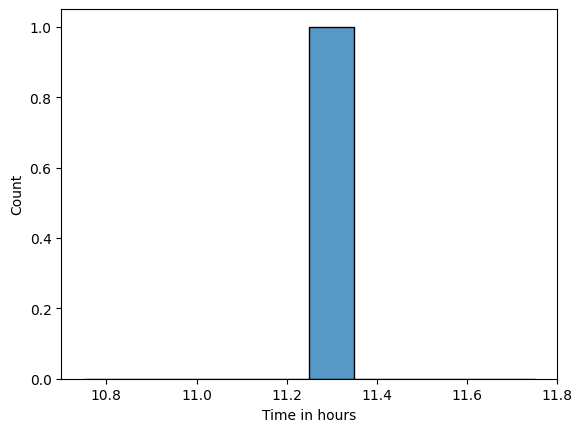

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

system_times = Stats.get_total_times()
system_times_min = [time_to_minutes(time) for time in system_times]
system_times_hours = [time / 60 for time in system_times_min]



# Plot the histogram
sns.histplot(system_times_hours, bins=10)
plt.xlabel('Time in hours')





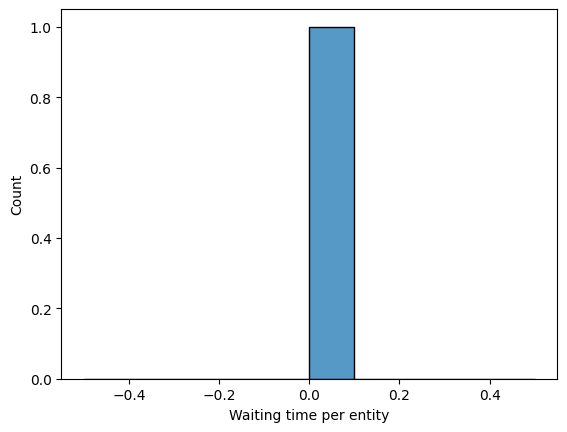

In [93]:
waiting_times = Stats.get_waiting_times()
waiting_times_min = [time_to_minutes(time) for time in waiting_times]
waiting_times_hours = [time / 60 for time in waiting_times_min]

sns.histplot(waiting_times_hours, bins=10)
plt.xlabel('Waiting time per entity');

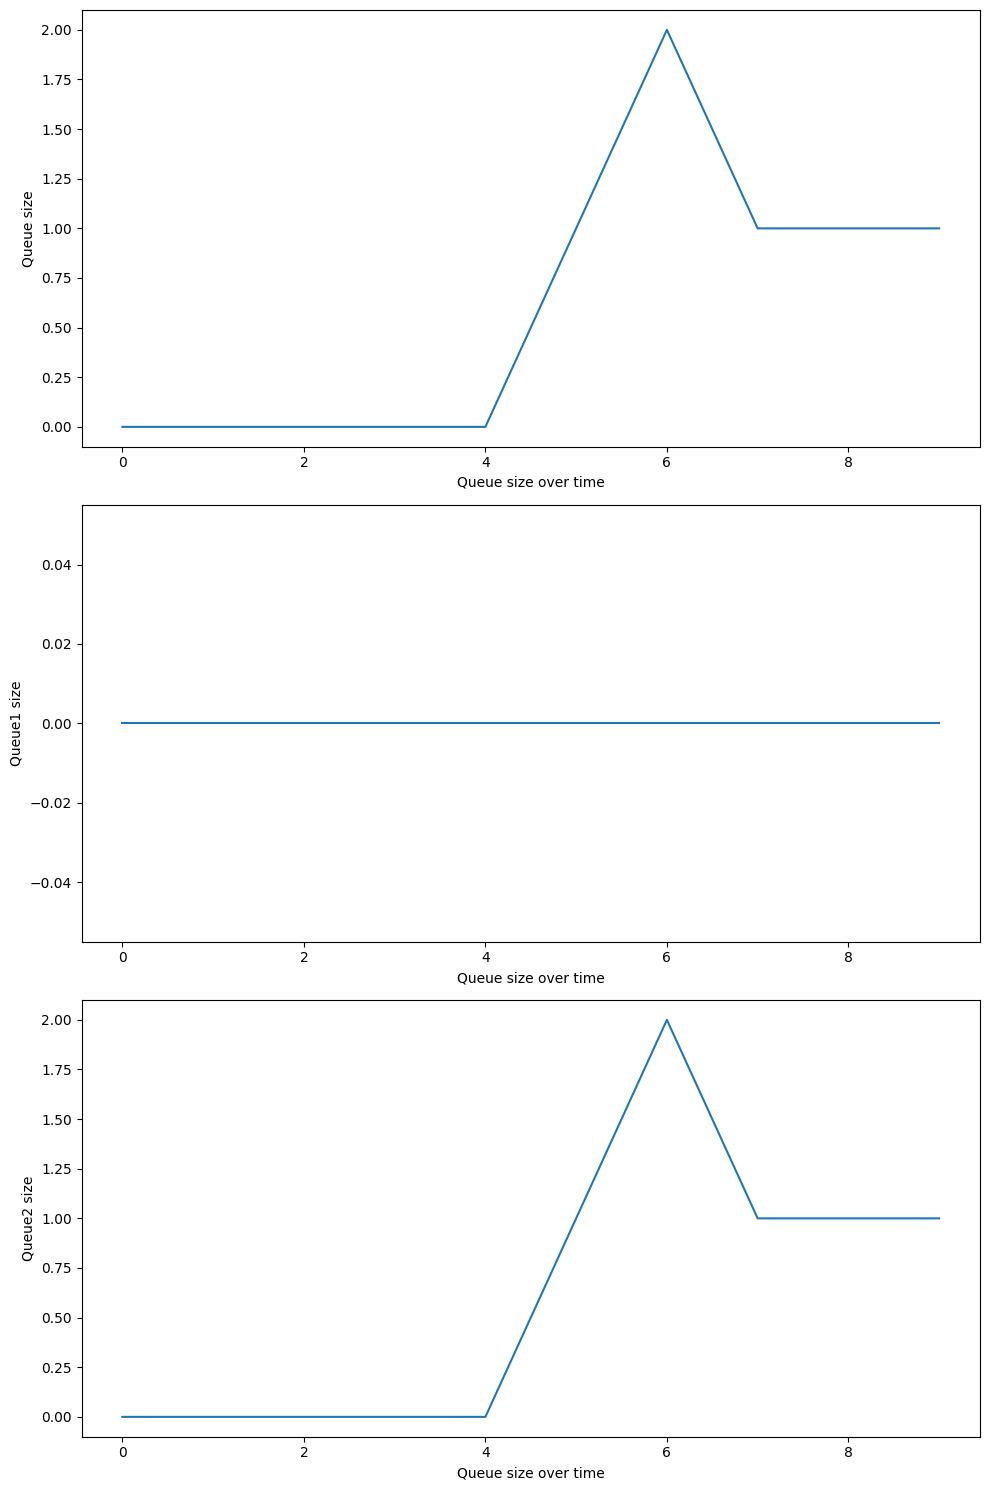

In [94]:
resource_queue = Stats.queue_size_over_time("berth_type")
resource_queue1 = Stats.queue_size_over_time("berth_type1")
resource_queue2 = Stats.queue_size_over_time("berth_type2")

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 1: Queue size over time
axs[0].plot(range(len(resource_queue)), resource_queue)
axs[0].set_ylabel('Queue size')
axs[0].set_xlabel('Queue size over time')

# Plot 2: System times histogram
axs[1].plot(range(len(resource_queue1)), resource_queue1)
axs[1].set_ylabel('Queue1 size')
axs[1].set_xlabel('Queue size over time')

# Plot 3: Waiting times histogram
axs[2].plot(range(len(resource_queue2)), resource_queue2)
axs[2].set_ylabel('Queue2 size')
axs[2].set_xlabel('Queue size over time')

plt.tight_layout()
plt.show()